In [1]:
from math import exp, sqrt, isclose
from statistics import fmean, pstdev
from random import uniform
from copy import deepcopy
from tqdm import tqdm, trange
from matplotlib import pyplot as plt

## read data

In [2]:
def normalization_factors(xss):
    return [(fmean(xs), pstdev(xs)) for xs in zip(*xss)]

def normalized_input(xss, stats):
    return [[(x - m) / s if s > 0 else 0 for x, (m, s) in zip(xs, stats)] for xs in xss]

def n_factors_test():
    lst = [[1, 2, 3, 4, 6], [2, 3, 4, 5, 6], [3, 4, 5, 6, 6]]
    n_factors = normalization_factors(lst)
    n_factors_true = [(2, sqrt(14/3 - 4)), 
                        (3, sqrt(29/3 - 9)), 
                        (4, sqrt(50/3 - 16)), 
                        (5, sqrt(77/3 - 25)), 
                        (6, 0)]
    for (m, s), (mt, st) in zip(n_factors, n_factors_true):
        assert m == mt and isclose(s, st)
    
    doubled = normalization_factors(normalized_input(lst, n_factors))
    doubled_true = [(0, 1), (0, 1), (0, 1), (0, 1), (0, 0)]
    for (m, s), (mt, st) in zip(doubled, doubled_true):
        assert m == mt and isclose(s, st)

In [3]:
def read_train(filename):
    with open(filename) as f:
        data = f.readlines()
    
    # read column headers
    line = [item.strip() for item in data[0].split(',')]
    attr_vars = line[:-1]
    class_var = line[-1]
    
    class_count = 0
    class_name_to_idx = {}
    class_idx_to_name = []
    
    x_train = []
    y_train = []

    # read train data
    for line in data[1:]:
        line = [item.strip() for item in line.split(',')]
        c = line[-1]
        if c not in class_name_to_idx:
            class_name_to_idx[c] = class_count
            class_idx_to_name.append(c)
            class_count += 1
        x_train.append([float(val) for val in line[:-1]])
        y_train.append(class_name_to_idx[c])
        
    stats = normalization_factors(x_train)
    x_train = normalized_input(x_train, stats)
    
    return attr_vars, class_var, class_name_to_idx, class_idx_to_name, list(zip(x_train, y_train)), stats, len(x_train)

In [4]:
def read_test(filename, stats):
    with open(filename) as f:
        data = f.readlines()
    
    x_test = []
    for line in data[1:]:
        line = [item.strip() for item in line.split(',')]
        x_test.append([float(val) for val in line])
    
    return normalized_input(x_test, stats)

## activation and loss functions

In [5]:
sigmoid = lambda xs: [1 / (1 + exp(-x)) for x in xs]
sigmoid_prime = lambda x: 1 / (1 + exp(-x)) * (1 - 1 / (1 + exp(-x)))

relu = lambda xs: [x if x > 0 else 0 for x in xs]
relu_prime = lambda x: 1 if x > 0 else 0

def softmax(xs):
    numer = [exp(x) for x in xs]
    denom = sum(numer)
    return [x / denom for x in numer]

def sel(network_output, label):
    return (1 - 2 * network_output[label] + sum([val**2 for val in network_output])) / len(network_output)

def softmax_sel_prime(k, layer, label):
    res = 0
    for i, val in enumerate(layer):
        if k == i:
            ltemp = exp(val) / sum([exp(x) for x in layer]) * (1 - exp(val) / sum([exp(x) for x in layer]))
            # assert ltemp >= 0
        else:
            ltemp = -exp(val) / sum([exp(x) for x in layer]) * exp(layer[k]) / sum([exp(x) for x in layer])
            # assert ltemp <= 0
        if i == label:
            rtemp = -2 + 2 * exp(val) / sum([exp(x) for x in layer])
            # assert rtemp <= 0
        else:
            rtemp = 2 * exp(val) / sum([exp(x) for x in layer])
            # assert rtemp >= 0
        res += ltemp * rtemp
    return res / len(layer)

def sigmoid_sel_prime(k, layer, label):
    ltemp = sigmoid_prime(layer[k])
    if k == label:
        rtemp = 2 + 2 * exp(layer[k]) / sum([exp(x) for x in layer])
    else:
        rtemp = 2 * exp(layer[k]) / sum([exp(x) for x in layer])
    return ltemp * rtemp / len(layer)

In [6]:
def activation_test():
    lst = [-2, -1, 0, 1, 2]
    lst_sigmoid = sigmoid(lst)
    lst_sigmoid_true = [0.119202922022, 
                        0.26894142137, 
                        0.5, 
                        0.73105857863, 
                        0.880797077978]
    for x1, x2 in zip(lst_sigmoid, lst_sigmoid_true):
        assert isclose(x1, x2)

## neural network functions

In [7]:
def forward(layer_sizes, activation, final_act, weights, x):
    layers_pre_act = [x]
    layers = [x]

    for i, (lsize, rsize) in enumerate(zip(layer_sizes, layer_sizes[1:])):
        layers_pre_act.append([sum([weights[i][j][k] * (layers[-1] + [1])[j] 
                              for j in range(lsize + 1)]) 
                         for k in range(rsize)])
        
        act = activation if i < len(layer_sizes) - 2 else final_act
        layers.append(act(layers_pre_act[-1]))
        
    return layers, layers_pre_act

def forward_test():
    layer_sizes = (1, 1, 2)
    activation = sigmoid
    final_act = softmax
    weights = [
        [[1], [2]],
        [[3, 4], [5, 6]]
    ]
    x = [7]
    print(forward(layer_sizes, activation, final_act, weights, x))

In [8]:
def classify(class_idx_to_name, layer_sizes, activation, final_act, weights, x):
    layers, layers_pre_act = forward(layer_sizes, activation, final_act, weights, x)
    final_layer = layers[-1]
    return class_idx_to_name[max(range(layer_sizes[-1]), key=lambda x: final_layer[x])]

In [9]:
def backward(layer_sizes, 
             activation_prime, 
             final_act_loss_prime, 
             old_weights, 
             weights, 
             layers, 
             layers_pre_act, 
             step, 
             y):
    # compute deltas in reverse order
    deltas = [[final_act_loss_prime(k, layers_pre_act[-1], y) 
               for k in range(layer_sizes[-1])]]
    for j in range(len(layer_sizes) - 2, 0, -1):
        deltas.append([sum([
            activation_prime(layers_pre_act[j][k]) * old_weights[j][k][l] * deltas[-1][l] 
            for l in range(layer_sizes[j + 1])
        ]) for k in range(layer_sizes[j])])
    deltas.reverse()
    
    # update weights
    for i in range(1, len(layer_sizes)):
        for j in range(layer_sizes[i - 1] + 1):
            for k in range(layer_sizes[i]):
                weights[i - 1][j][k] -= step * (layers[i - 1] + [1])[j] * deltas[i - 1][k]

In [10]:
def train_one_epoch(weights, 
                    layer_sizes, 
                    activation, 
                    activation_prime, 
                    final_act, 
                    final_act_loss_prime, 
                    batch_size, 
                    step, 
                    train_data):
    for i, (x, y) in enumerate(train_data):
        if i % batch_size == 0:
            old_weights = deepcopy(weights)
            
        layers, layers_pre_act = forward(layer_sizes, activation, final_act, old_weights, x)
        
        backward(layer_sizes, 
                 activation_prime, 
                 final_act_loss_prime, 
                 old_weights,
                 weights,
                 layers,
                 layers_pre_act,
                 step, 
                 y)

In [11]:
def run_tests():
    n_factors_test()
    activation_test()
    # forward_test()
    print("All tests passed!")

## experiments

In [21]:
dataset = "diabetes"

In [22]:
train_file = f"datasets/{dataset}/train.txt"
test_file = f"datasets/{dataset}/test.txt"
output_file = f"datasets/{dataset}/out.txt"

In [23]:
attr_vars, class_var, class_name_to_idx, class_idx_to_name, train_data, stats, n = read_train(train_file)
x_test = read_test(test_file, stats)

In [24]:
run_tests()

All tests passed!


In [41]:
hidden_layer_sizes = {
    "diabetes": [6, 3],
    "toy": [2],
    "tiny": [1]
}

In [42]:
layer_sizes = (len(attr_vars), *hidden_layer_sizes[dataset], len(class_name_to_idx))
print(layer_sizes)
batch_size = 20

learning_rate = 1
max_epochs = 1000

activation = sigmoid
# activation = relu
activation_prime = sigmoid_prime
# activation_prime = relu_prime
# final_act = sigmoid
final_act = softmax
loss = sel
# final_act_loss_prime = sigmoid_sel_prime
final_act_loss_prime = softmax_sel_prime

(8, 6, 3, 2)


In [48]:
tqdm._instances.clear()

In [49]:
weights = [[[uniform(-1, 1) 
             for _ in range(rsize)] 
            for _ in range(lsize + 1)] 
           for lsize, rsize in zip(layer_sizes, layer_sizes[1:])]
step_sizes = []
losses = []

step = learning_rate
t = tqdm(total=max_epochs, unit="ep")
for e in range(max_epochs):
    train_one_epoch(
        weights,
        layer_sizes, 
        activation, 
        activation_prime, 
        final_act, 
        final_act_loss_prime, 
        batch_size, 
        step / n, 
        train_data)
    
    step_sizes.append(step)

    avg_loss = 0
    for x, y in train_data:
        layers, _ = forward(layer_sizes, activation, final_act, weights, x)
        avg_loss += loss(layers[-1], y)
    avg_loss /= n

    if losses:
        if avg_loss > losses[-1]:
            step *= 0.8
        else:
            step *= 1.1

    losses.append(avg_loss)

    if step < 0.000001:
        t.update(n=max_epochs-e)
        t.close()
        break
    else:
        t.update()
t.close()

100%|███████████████████████████████████████████████████████████| 1000/1000 [02:04<00:00,  8.05ep/s]


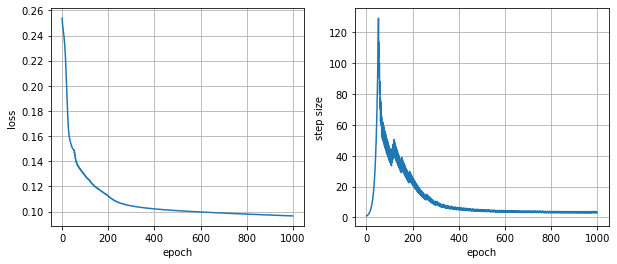

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
for ax, data, label in ((ax1, losses, "loss"), (ax2, step_sizes, "step size")):
    ax.grid(visible=True)
    ax.set_xlabel('epoch')
    ax.set_ylabel(label)
    ax.ticklabel_format(style='plain', useOffset=False)
    ax.plot(range(e + 1), data)

In [56]:
res = []
for x in x_test:
    y = classify(class_idx_to_name, layer_sizes, activation, final_act, weights, x)
    res.append(y)
    
with open(output_file, 'w') as f:
    print('\n'.join(res))
    f.write('\n'.join(res))

1
1
1
1
0
0
0
1
0
0
1
0
1
0
